In [92]:
# NEED TO DO: update comments to account for list of folders to go through, not just a single folder

import numpy as np
import os
import matplotlib.pyplot as plt
from scipy import signal
from astropy.io import fits
from astropy.visualization import astropy_mpl_style
import pickle
    
plt.style.use(astropy_mpl_style)


# Steps:
# look at .out file with all angles
# make dictionary with key=ffi_number and value equal to a tuple of all angles/values we want
# pickle dictionary to the angle folder
#
# look at the fits files with all of the numpy arrays for each image
# clip, median filter to reduce resolution, sigma-clip, and normalize the image
# pickle the image to the ccd folder, then repeat for each image

class Preprocessing:
    def __init__(self, fits_folder_paths, angle_folder, ccd_folder, raw_angles_file_paths):
        '''
        initializes a Preprocessing object for this class. It 
        identifies the paths to the folders containing fits files, as 
        well as the names of the folders where the angles and ccd 
        numpy arrays will be kept.
        '''
        self.fits_folder_paths = fits_folder_paths
        self.angle_folder = angle_folder
        self.ccd_folder = ccd_folder
        self.raw_angles_file_paths = raw_angles_file_paths
    
    def get_arr(self, fits_filename, fits_folder_path):
        '''
        input: the name of the fits file we need to get info out of
                the path to the fodler where the fits file is in
        output: numpy array of four ccd images
        '''
#         fits.info(fits_folder_paths + fits_filename)
        numpy_arr = fits.getdata(fits_folder_path + fits_filename, ext=0)
        return numpy_arr
    
    def process_angles(self):
        '''
        input: None
        output: None
        iterates over each folder, and iterates through the file line by line and creates a
        dictionary with key=image number and value=tuple of values.
        It then pickles the dictionary and saves it into the angle 
        folder with the name "angles_data.pkl"
        '''
        angles_dic = {'title': ('E3el', 'E3az', 'M3el', 'M3az', '1/ED', '1/MD', '1/ED^2', '1/MD^2')}
        #FIN ED MD Eel Eaz Mel Maz E1el E1az E2el E2az E3ez E3az E4el E4az M1el M1az M2el M2az M3el M3az M4el M4az
        
        # opens file and reads line by line
        for file_path in self.raw_angles_file_paths:
            with open(file_path, 'r') as file:
                for line in file.read().split('\n')[1:]:
                    arr = line.strip().split()
                    if len(arr)<2: break
                    arr = [float(arr[i]) if i>0 else str(arr[i]) for i in range(len(arr))]
                    # print(arr)
                    # angles_dic[arr[0]] = tuple(arr[1:] + [1/arr[1], 1/arr[2]] + [1/arr[1]**2, 1/arr[2]**2]) # not scaling the distances
                    # scaling the distances by 1/50 and angles by pi/180
                    angles_dic[arr[0]] = tuple(ang*np.pi/180 for ang in [arr[1:]] + [1/(arr[1]/50), 1/(arr[2]/50)] + [1/(arr[1]/50)**2, 1/(arr[2]/50)**2])
                    angles_dic[arr[0]] = [round(elt, 2) for elt in angles_dic[arr[0]]]
                    
        # # print(angles_dic)
        # print(len(angles_dic.keys()))
        # for k,v in angles_dic.items():
        #     print(k,v)

        return
    
        with open(self.angle_folder + 'angles_O13_data.pkl', 'wb') as file:
            pickle.dump(angles_dic, file)
    
    def save_process_CCD(self, arr, reduced_px, alpha, fits_filename):
        '''
        input: arr: numpy array of ccd image
                    kernel_size: size of kernel for median filter
                    reduced_px: number of pixels of the new image
        output: None
        takes the numpy array, puts it through a median filter while 
        reducing the pixel size. Then sigma-clips the resulting
        image to get rid of outliers, and normalizes the numbers
        to be between 0 and 1. Then pickles the array and saves
        it to the ccd folder with the name <filename + '_ccd'>
        '''
        
        # setting min and max values for pixels, clipping
        arr = np.clip(arr, 0, 633118)
        arr_nocross = np.zeros((4096, 4096))
        new_arr = np.ndarray((reduced_px, reduced_px))

        print('---------------------------------')
        fig,ax = plt.subplots()
        im = ax.imshow(arr, cmap="gray")
        plt.grid(visible=False)
        # colorbar = plt.colorbar()
        colorbar = fig.colorbar(im)
        plt.show()
        plt.close()


        # # reduces the pixel resolution by taken the average of 
        # # each box
        # kernel_step = 4096 // reduced_px
        # x = 0
        # y = 44
        # y_new_arr = 0 # indices of reduced-pixel array
        # x_new_arr = 0
        # x_thr = False # False if x or y have not passed the middle
        # y_thr = False # buffer area "jump", true if past it
                
        # while x < 4096:
        #     if x > 2047 and not x_thr:
        #         # handles the buffer jump for the x-axis
        #         x_thr = True
        #         x = 2108
        #     while y < 4227:
        #         if y > 2091 and not y_thr:
        #             # handles the buffer jump for the y-axis
        #             y_thr = True
        #             y = 2180
        #         # takes the median of a kernel and sets the value for the new array
        #         new_arr[x_new_arr,y_new_arr] = np.median(arr[x:x+kernel_step,y:y+kernel_step])
        #         # increments y-indices
        #         y += kernel_step 
            #     y_new_arr += 1
            # # increments x-indices and resets y-indices
            # x += kernel_step
            # x_new_arr += 1
            # y = 44
            # y_new_arr = 0
            # y_thr = False



        kernel_step = 4096 // reduced_px
        x = 0
        y = 44
        y_new_arr = 0 # indices of reduced-pixel array
        x_new_arr = 0
        x_thr = False # False if x or y have not passed the middle
        y_thr = False # buffer area "jump", true if past it

        new_x = 0
        new_y = 0

        # print(arr_nocross.shape)
        
        while x < 4096:
            if x > 2047 and not x_thr:
                # handles the buffer jump for the x-axis
                x_thr = True
                x = 2108
            while y < 4227:
                if y > 2091 and not y_thr:
                    # handles the buffer jump for the y-axis
                    y_thr = True
                    y = 2180
                # takes the median of a kernel and sets the value for the new array
                # new_arr[x_new_arr,y_new_arr] = np.median(arr[x:x+kernel_step,y:y+kernel_step])
                arr_nocross[x_new_arr, y_new_arr] = arr[x,y]
                # increments y-indices
                y += 1 # kernel_step 
                y_new_arr += 1
            # increments x-indices and resets y-indices
            x += 1 # kernel_step
            x_new_arr += 1
            y = 44
            y_new_arr = 0
            y_thr = False
            # new_x+=1
            # new_y = 0

        print('---------------------------------')
        print('no cross:')
        # print(arr_nocross)
        fig,ax = plt.subplots()
        im = ax.imshow(arr_nocross, cmap="gray")
        plt.grid(visible=False)
        # colorbar = plt.colorbar()
        colorbar = fig.colorbar(im)
        plt.show()
        plt.close()


                

        # Sigma-clipping
        sigma = np.std(arr_nocross)
        avg = np.average(arr_nocross)
        arr_nocross = np.clip(arr_nocross, sigma-alpha*avg, sigma+alpha*avg)
        
        # normalizes array values to be between 0 and 1
        # new_arr = (new_arr - np.min(new_arr)) / (np.max(new_arr) - np.min(new_arr))

        
        print('sigma-clipped:')
        fig,ax = plt.subplots()
        im = ax.imshow(arr_nocross, cmap="gray")
        plt.grid(visible=False)
        # colorbar = plt.colorbar()
        colorbar = fig.colorbar(im)
        plt.show()
        plt.close()

        x = 0
        y = 0
        x_new = 0
        y_new = 0
        
        while x_new < reduced_px:
            while y_new < reduced_px:
                new_arr[x_new,y_new] = np.median(arr_nocross[x:x+kernel_step,y:y+kernel_step])
                y += kernel_step
                y_new += 1
            y = 0
            y_new = 0
            x += kernel_step
            x_new += 1

        # # set 2x2 pixels in each corner to 0 - ignore
        # new_arr[0][0], new_arr[1][0], new_arr[0][1], new_arr[1][1] = 0,0,0,0
        # new_arr[-1][-1], new_arr[-1][-2], new_arr[-2][-1], new_arr[-2][-2] = 0,0,0,0
        # new_arr[-1][0], new_arr[-1][1], new_arr[-2][0], new_arr[-2][1] = 0,0,0,0
        # new_arr[0][-1], new_arr[0][-2], new_arr[1][-1], new_arr[1][-2] = 0,0,0,0

        print('reduced:')
        fig,ax = plt.subplots()
        im = ax.imshow(new_arr, cmap="gray")
        plt.grid(visible=False)
        # colorbar = plt.colorbar()
        colorbar = fig.colorbar(im)
        plt.show()
        plt.close()

        # fig = plt.subplots(1, 1), figsize=(40, 7))
        # im_pred = axes[0].imshow(samples[i][b].cpu()[0], cmap="gray")
        # # plt.show(new_arr)
        # plt.close()
        # plt.imshow(new_arr, cmap="gray")
        # colorbar = plt.colorbar(new_arr)
        # plt.show()
        # plt.close()
        # print('---------------------------------')
        fig,ax = plt.subplots()
        im = ax.imshow(new_arr, cmap="gray")
        plt.grid(visible=False)
        # colorbar = plt.colorbar()
        colorbar = fig.colorbar(im)
        plt.show()
        plt.close()
        
        
        
        # # pickle and save
        # with open(self.ccd_folder + fits_filename[:-8] + '_ccd.pkl', 'wb') as file:      
        #     pickle.dump(new_arr, file)
    
    def run(self):
        '''
        input: None
        output: None
        runs the functionality described above using the functions within this class
        '''
        # # processes and saves angles
        # self.process_angles()
        # print('Angles done.')
        
        # processes and saves fits files, images
        counter = 0
        for folder_path in self.fits_folder_paths:
            for fits_filename in os.listdir(folder_path):
                if len(fits_filename) > 40 and fits_filename[-7:]=='fits.gz' and fits_filename[27] == '3':
                    # print(fits_filename, fits_filename[-4:], len(fits_filename))
                    arr = self.get_arr(fits_filename, folder_path)

                    # plt.imshow(arr, cmap="gray")
                    # plt.show()
                    # plt.close()
                    # print(arr.shape)

                    
                    self.save_process_CCD(arr, 16, 10, fits_filename)
                    print(fits_filename[27])
                    print(counter, fits_filename)
                    counter += 1
                else:
                    print('Skipped' + fits_filename)
        print('Images done.')


Skippedtess2018278081147-00008059-4-crm-ffi_dehoc.fits.gz
Skippedtess2018278081147-00008027-1-crm-ffi_dehoc.fits.gz
Skippedtess2018278081147-00007681-1-crm-ffi_dehoc.fits.gz
Skippedtess2018278081147-00007883-1-crm-ffi_dehoc.fits.gz
Skippedtess2018278081147-00007612-1-crm-ffi_dehoc.fits.gz
Skippedtess2018278081147-00008049-2-crm-ffi_dehoc.fits.gz
Skippedtess2018278081147-00007810-1-crm-ffi_dehoc.fits.gz
Skippedtess2018278081147-00007522-1-crm-ffi_dehoc.fits.gz
Skippedtess2018278081147-00007971-1-crm-ffi_dehoc.fits.gz
Skippedtess2018278081147-00007773-1-crm-ffi_dehoc.fits.gz
Skippedtess2018278081147-00007465-4-crm-ffi_dehoc.fits.gz
---------------------------------


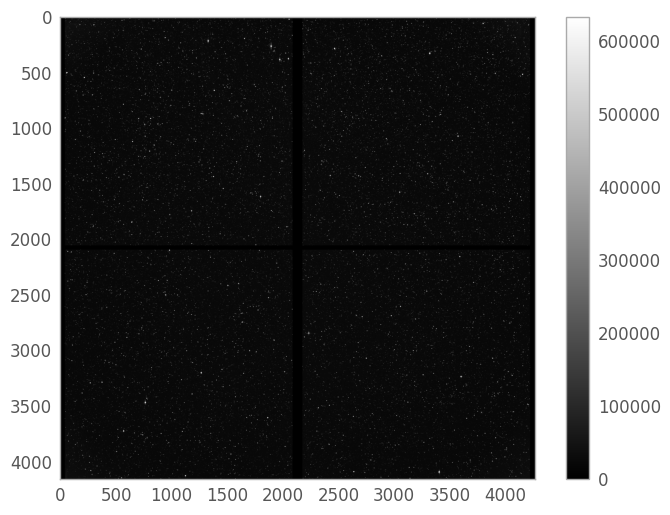

---------------------------------
no cross:


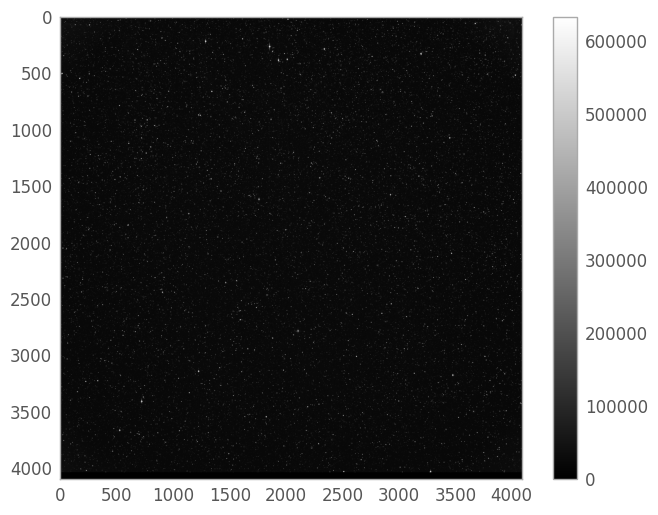

sigma-clipped:


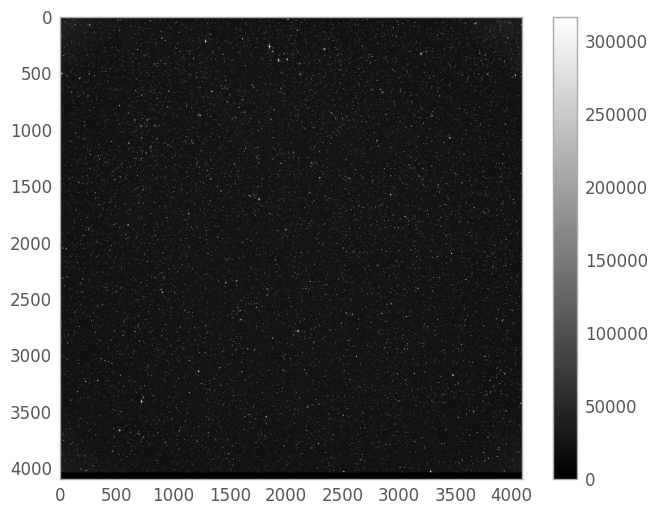

reduced:


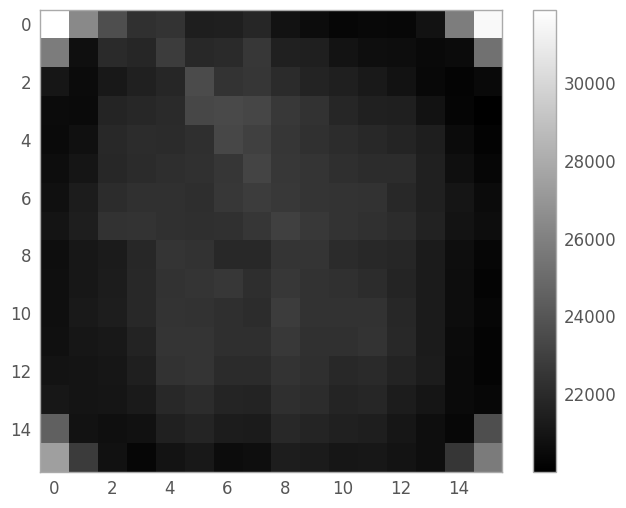

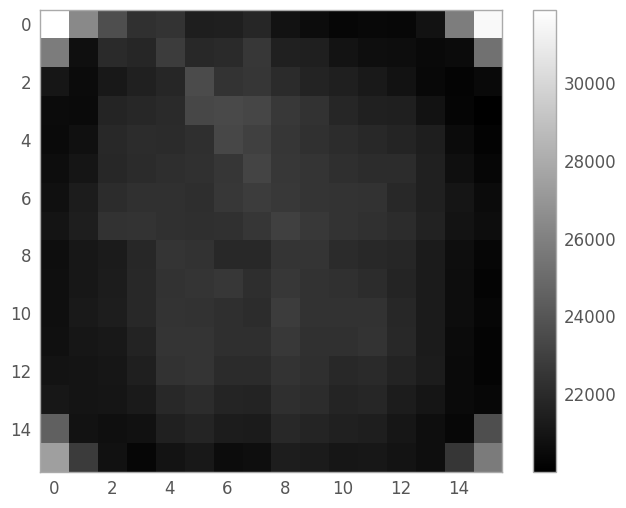

3
0 tess2018278081147-00007924-3-crm-ffi_dehoc.fits.gz
Skippedtess2018278081147-00007929-1-crm-ffi_dehoc.fits.gz
---------------------------------


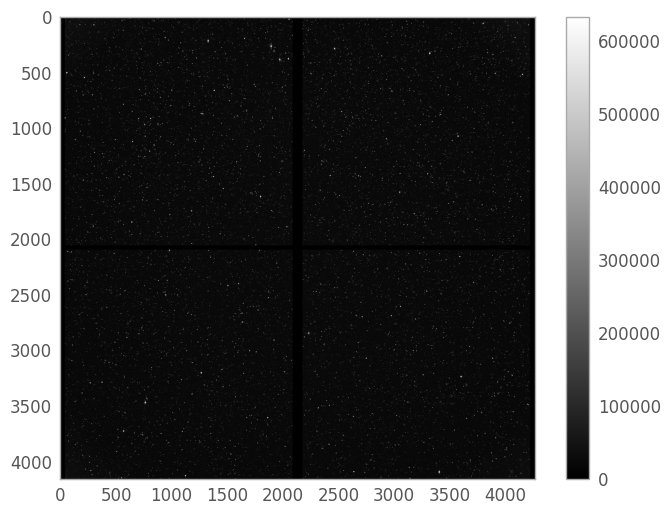

---------------------------------
no cross:


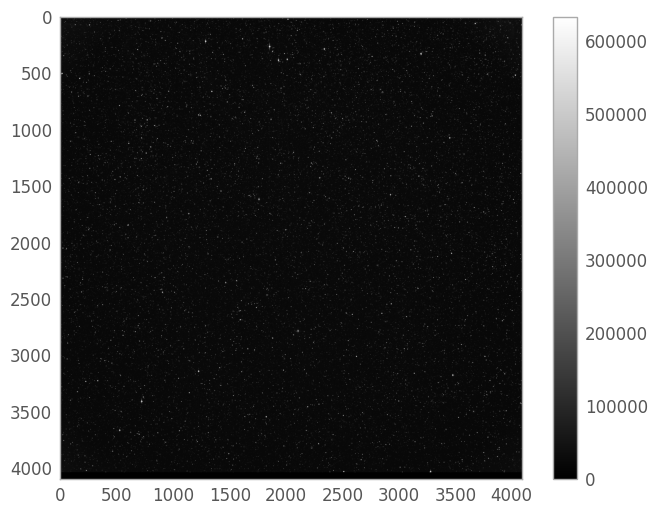

sigma-clipped:


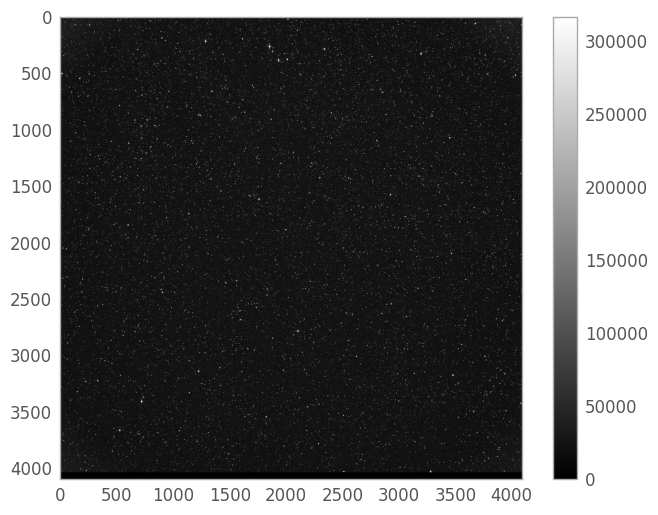

reduced:


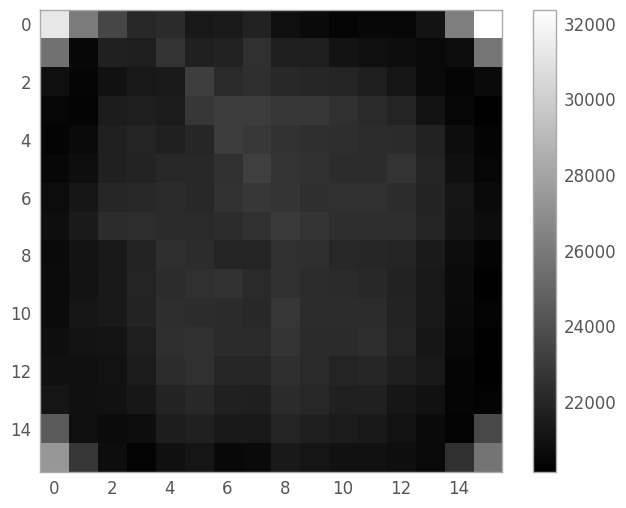

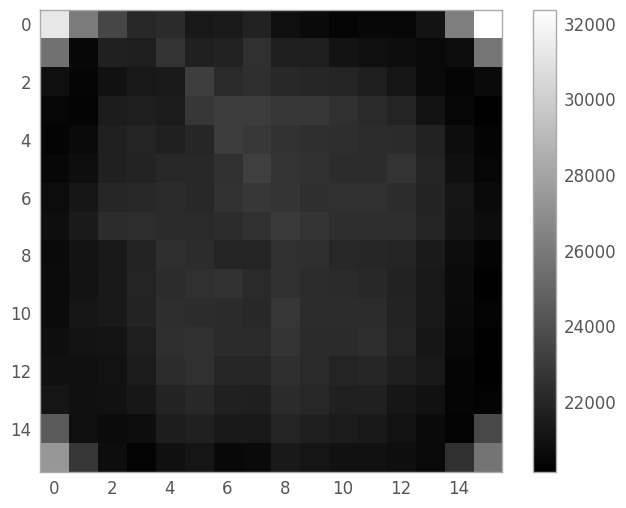

3
1 tess2018278081147-00007726-3-crm-ffi_dehoc.fits.gz
Skippedtess2018278081147-00007957-4-crm-ffi_dehoc.fits.gz
---------------------------------


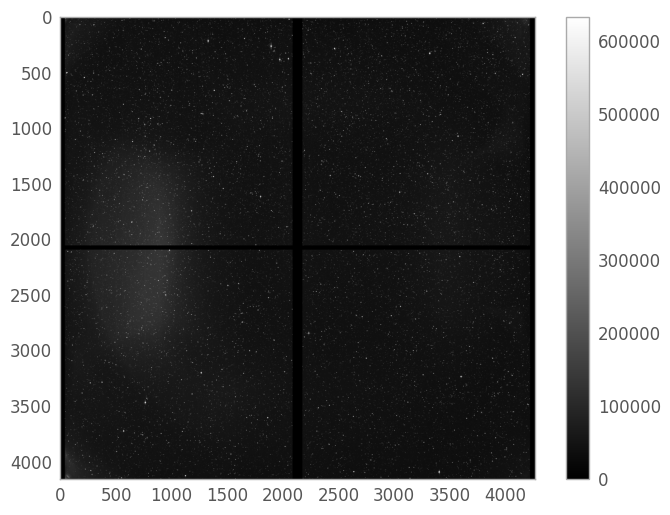

---------------------------------
no cross:


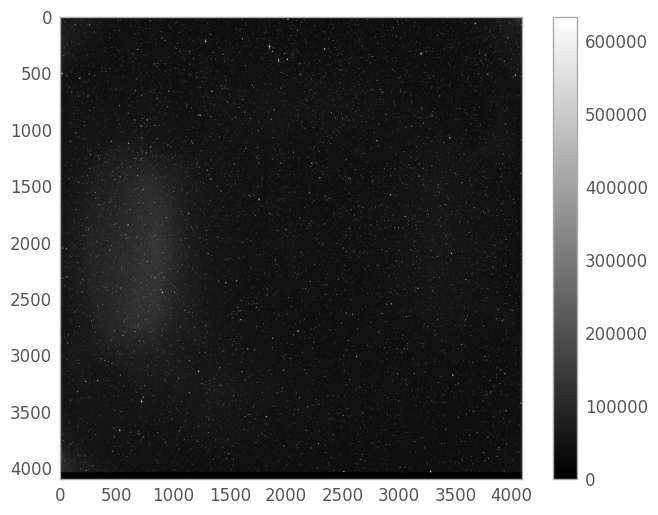

sigma-clipped:


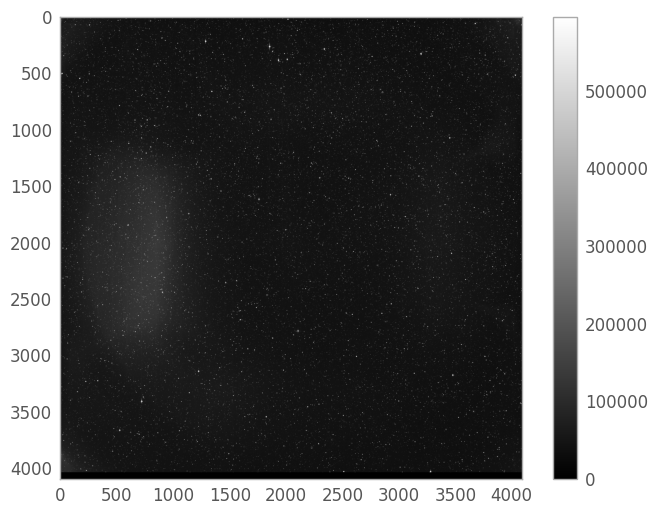

reduced:


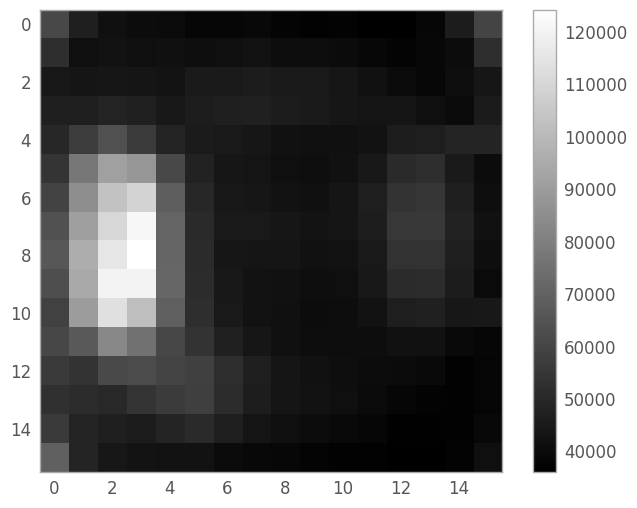

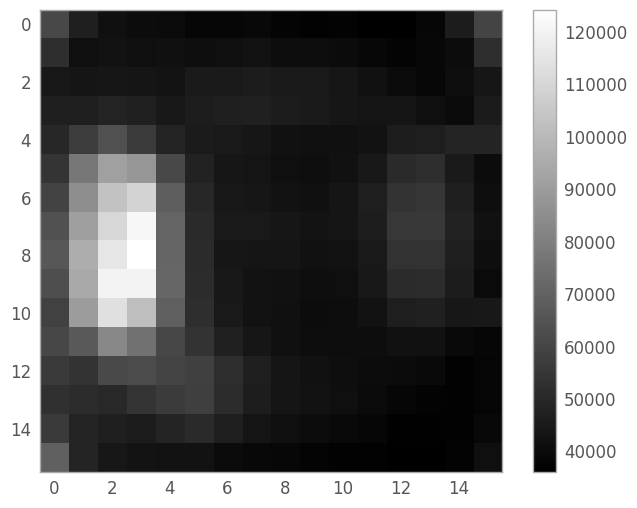

3
2 tess2018278081147-00007416-3-crm-ffi_dehoc.fits.gz
Skippedtess2018278081147-00007755-4-crm-ffi_dehoc.fits.gz
Skippedtess2018278081147-00007634-4-crm-ffi_dehoc.fits.gz
Skippedtess2018278081147-00008092-4-crm-ffi_dehoc.fits.gz
---------------------------------


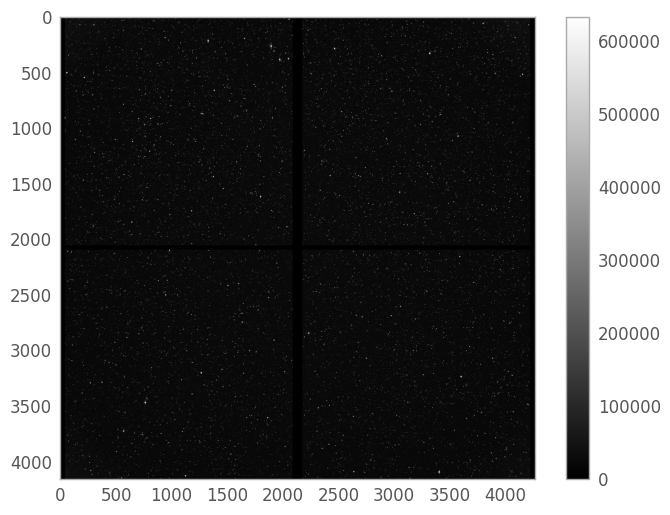

KeyboardInterrupt: 

In [93]:
fits_folder_paths = ["//pdo//users//roland//SL_data//O11_data//", "//pdo//users//roland//SL_data//O12_data//", "//pdo//users//roland//SL_data//O13_data//", "//pdo//users//roland//SL_data//O14_data//", "//pdo//users//roland//SL_data//O15_data//", "//pdo//users//roland//SL_data//O16_data//", "//pdo//users//roland//SL_data//O17_data//"][2:3]
angle_folder = "//pdo//users//jlupoiii//TESS//data//angles//"
ccd_folder = "//pdo//users//jlupoiii//TESS//data//ccds//"
raw_angles_file_paths = ["//pdo//users//roland//SL_data//altazzes//O11_altaz.out", "//pdo//users//roland//SL_data//altazzes//O12_altaz.out", "//pdo//users//roland//SL_data//altazzes//O13_altaz.out", "//pdo//users//roland//SL_data//altazzes//O14_altaz.out", "//pdo//users//roland//SL_data//altazzes//O15_altaz.out", "//pdo//users//roland//SL_data//altazzes//O16_altaz.out", "//pdo//users//roland//SL_data//altazzes//O17_altaz.out"][2:3]


processor_save_data = Preprocessing(fits_folder_paths, angle_folder, ccd_folder, raw_angles_file_paths)
processor_save_data.run()